<a href="https://colab.research.google.com/github/Dikabagas/Final_Tubes_TKC-234_244/blob/main/InceptionV3_%26_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/TKC"

In [ ]:
!ls

drive  sample_data


In [ ]:
%cd /content/drive/MyDrive/TKC/chest_xray/

/content/drive/MyDrive/TKC/chest_xray


In [ ]:
base_dir = "/content/drive/My Drive/TKC/chest_xray"

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

pneumonia_train_dir = os.path.join(train_dir, 'PNEUMONIA')
normal_train_dir = os.path.join(train_dir, 'NORMAL')

pneumonia_test_dir = os.path.join(test_dir, 'PNEUMONIA')
normal_test_dir = os.path.join(test_dir, 'NORMAL')

In [ ]:
print('total training Pneumonia images :', len(os.listdir(pneumonia_train_dir)))
print('total training Normal images :', len(os.listdir(normal_train_dir)))

print('\ntotal test Pneumonia images :', len(os.listdir(pneumonia_test_dir)))
print('total test Normal images :', len(os.listdir(normal_test_dir)))

total training Pneumonia images : 3883
total training Normal images : 1349

total test Pneumonia images : 390
total test Normal images : 234


In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

height = 224
width = 224
batch_size = 32

generator_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_gen = ImageDataGenerator(rescale = 1./255)

train_generator = generator_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

test_generator = val_gen.flow_from_directory(
    test_dir,
    target_size=(height,width),
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpeg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (224,224))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
# Gather data test
test_data = []
test_label = []
for r, d, f in os.walk(test_dir):
    for file in f:
        if ".jpeg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (224,224))
            test_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            test_label.append(label)

test_data = np.array(test_data)
test_label = np.array(test_label)

In [ ]:
# Tampilkan shape dari data train, data val dan data test
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Test Data = ", test_data.shape)
print("Test Label = ", test_label.shape)

Train Data =  (5232, 224, 224, 3)
Train Label =  (5232,)
Test Data =  (624, 224, 224, 3)
Test Label =  (624,)


In [ ]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_test = test_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [24 24 24]
Data setelah di-normalisasi  [0.09411765 0.09411765 0.09411765]


In [ ]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL'
 'NORMAL' 'NORMAL']
Label setelah di-encoder  [0 0 0 0 0 0 0 0 0 0]


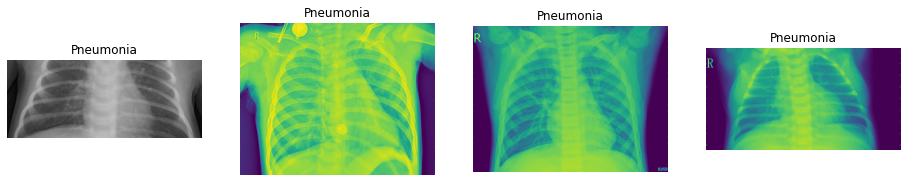

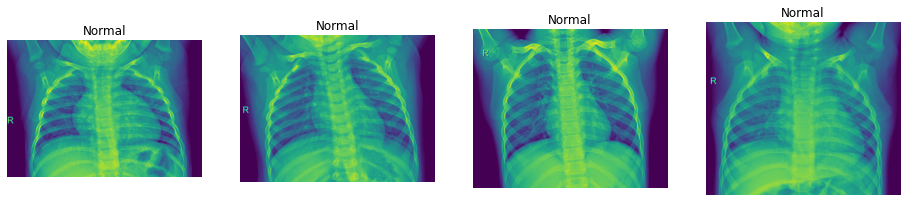

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

pneumonia_images = os.listdir(pneumonia_train_dir)
normal_images = os.listdir(normal_train_dir)

fname1 = [os.path.join(pneumonia_train_dir,fname)
        for fname in pneumonia_images[:4]]

fname2 = [os.path.join(normal_train_dir,fname)
        for fname in normal_images[:4]]

ncolu = 4
nrow = 2
fig = plt.gcf()
fig.set_size_inches(ncolu*4,nrow*4)
for i,fname in enumerate(fname1):
    sp = plt.subplot(2,4,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    plt.title('Pneumonia')
    plt.imshow(img)
plt.show()

ncolu = 4
nrow = 2
fig = plt.gcf()
fig.set_size_inches(ncolu*4,nrow*4)
for i,fname in enumerate(fname2):
    sp = plt.subplot(2,4,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    plt.title('Normal')
    plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, MaxPool2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
baseModel =InceptionV3(include_top=False, input_tensor=Input(shape=(224, 224, 3)), classifier_activation='softmax', pooling = max)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
x = layers.Flatten()(baseModel.output)
x = layers.Dense(1024, activation='relu', input_dim=512)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)                 
x = layers.Dense(2, activation='softmax')(x)

In [ ]:
model = Model(baseModel.input, x)

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

METRICS = [
    'acc',
    Precision(name='precision'),
    Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
TRAIN_IMG_COUNT = train_data.shape[0]
TEST_IMG_COUNT = test_data.shape[0]
BATCH_SIZE = 32

In [ ]:
H = model.fit(train_generator,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=25,
              validation_data=test_generator,
              validation_steps=TEST_IMG_COUNT // BATCH_SIZE
              )

Epoch 1/25
163/163 [==============================] - 172s 960ms/step - loss: 0.8852 - acc: 0.8962 - precision: 0.8962 - recall: 0.8962 - val_loss: 0.2508 - val_acc: 0.9161 - val_precision: 0.9161 - val_recall: 0.9161
Epoch 2/25
163/163 [==============================] - 152s 931ms/step - loss: 0.1908 - acc: 0.9304 - precision: 0.9304 - recall: 0.9304 - val_loss: 0.3046 - val_acc: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 3/25
163/163 [==============================] - 193s 1s/step - loss: 0.1527 - acc: 0.9467 - precision: 0.9467 - recall: 0.9467 - val_loss: 0.6017 - val_acc: 0.8010 - val_precision: 0.8010 - val_recall: 0.8010
Epoch 4/25
163/163 [==============================] - 214s 1s/step - loss: 0.1559 - acc: 0.9462 - precision: 0.9462 - recall: 0.9462 - val_loss: 0.2095 - val_acc: 0.9260 - val_precision: 0.9260 - val_recall: 0.9260
Epoch 5/25
163/163 [==============================] - 142s 872ms/step - loss: 0.1246 - acc: 0.9548 - precision: 0.9548 - recall: 0.954

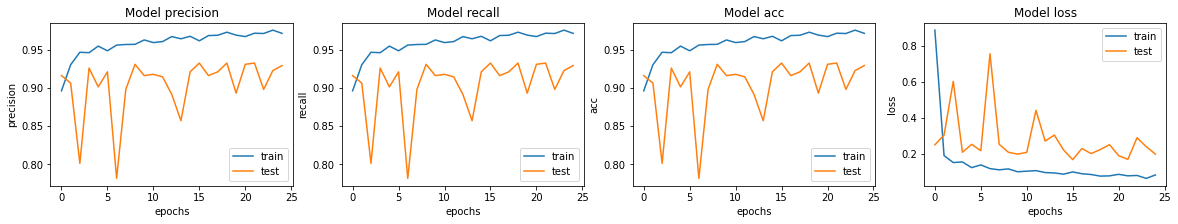

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'acc', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'test'])

In [ ]:
target_dir = "/content/drive/MyDrive/TKC"
model.save(target_dir + '/model2.h5')

In [ ]:
loss, acc, prec, rec = model.evaluate(test_generator)
print(f"Loss = {loss * 100:.2f} %")
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

20/20 [==============================] - 14s 681ms/step - loss: 0.1980 - acc: 0.9279 - precision: 0.9279 - recall: 0.9279
Loss = 19.80 %
Accuracy = 92.79 %
Precision = 92.79 %
Recall = 92.79 %


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

pred_labels = model.predict(test_generator)
y_pred = np.argmax(pred_labels, axis=1)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.92      0.88      0.90       234
   PNEUMONIA       0.93      0.95      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Normalized confusion matrix


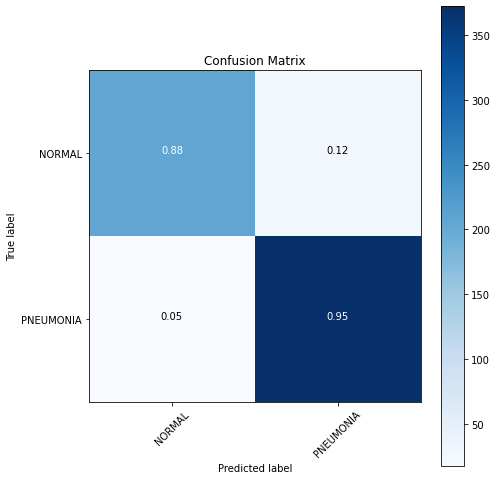

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title="Confusion Matrix" )

In [ ]:
sp=(0.95)/(0.95+0.05)
ppv=(0.88)/(0.88+0.12)
npv=(0.12)/(0.12+0.95)
print("Specificity: ", sp)
print("PPV: ", ppv)
print("NPV: ", npv)

Specificity:  0.95
PPV:  0.88
NPV:  0.11214953271028039


In [ ]:
baseModel = VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)), classifier_activation='softmax', pooling = max)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
x = layers.Flatten()(baseModel.output)
x = layers.Dense(1024, activation='relu', input_dim=512)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)                 
x = layers.Dense(2, activation='softmax')(x)

In [ ]:
model1 = Model(baseModel.input, x)

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
TRAIN_IMG_COUNT = train_data.shape[0]
TEST_IMG_COUNT = test_data.shape[0]
BATCH_SIZE = 32

In [ ]:
H = model1.fit(train_generator,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=25,
              validation_data=test_generator,
              validation_steps=TEST_IMG_COUNT // BATCH_SIZE
              )

Epoch 1/25
163/163 [==============================] - 174s 993ms/step - loss: 0.2666 - acc: 0.9035 - precision: 0.9061 - recall: 0.9061 - val_loss: 0.1926 - val_acc: 0.9326 - val_precision: 0.9326 - val_recall: 0.9326
Epoch 2/25
163/163 [==============================] - 146s 892ms/step - loss: 0.1234 - acc: 0.9563 - precision: 0.9563 - recall: 0.9563 - val_loss: 0.1549 - val_acc: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 3/25
163/163 [==============================] - 144s 883ms/step - loss: 0.1237 - acc: 0.9569 - precision: 0.9569 - recall: 0.9569 - val_loss: 0.1785 - val_acc: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 4/25
163/163 [==============================] - 148s 908ms/step - loss: 0.0920 - acc: 0.9669 - precision: 0.9669 - recall: 0.9669 - val_loss: 0.2276 - val_acc: 0.9359 - val_precision: 0.9359 - val_recall: 0.9359
Epoch 5/25
163/163 [==============================] - 144s 884ms/step - loss: 0.0955 - acc: 0.9644 - precision: 0.9644 - recall:

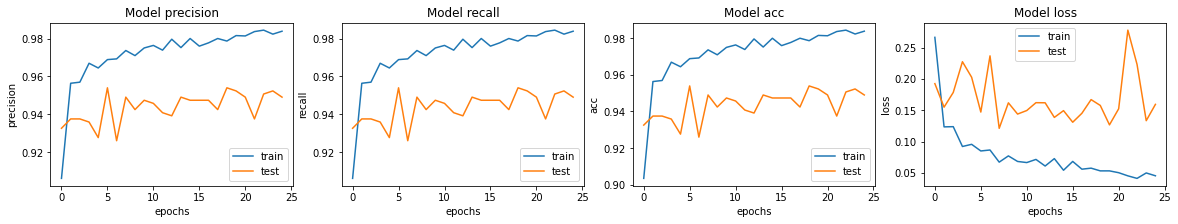

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'acc', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'test'])

In [ ]:
target_dir = "/content/drive/MyDrive/TKC"
model1.save(target_dir + '/model3.h5')

In [ ]:
loss, acc, prec, rec = model1.evaluate(test_generator)
print(f"Loss = {loss * 100:.2f} %")
print(f"Accuracy = {acc * 100:.2f} %")
print(f"Precision = {prec * 100:.2f} %")
print(f"Recall = {rec * 100:.2f} %")

20/20 [==============================] - 11s 515ms/step - loss: 0.1555 - acc: 0.9503 - precision: 0.9503 - recall: 0.9503
Loss = 15.55 %
Accuracy = 95.03 %
Precision = 95.03 %
Recall = 95.03 %


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

pred_labels = model1.predict(test_generator)
y_pred = np.argmax(pred_labels, axis=1)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.95      0.91      0.93       234
   PNEUMONIA       0.95      0.97      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624



In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Normalized confusion matrix


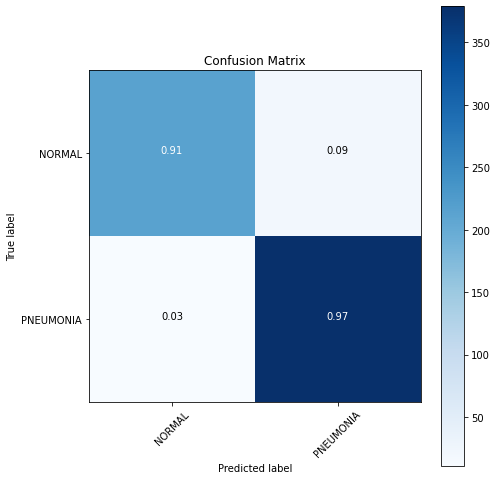

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title="Confusion Matrix" )

In [ ]:
sp=(0.97)/(0.97+0.03)
ppv=(0.91)/(0.91+0.09)
npv=(0.09)/(0.09+0.97)
print("Specificity: ", sp)
print("PPV: ", ppv)
print("NPV: ", npv)

Specificity:  0.97
PPV:  0.91
NPV:  0.08490566037735849


Model : model2.h5
Predicted Label : NORMAL
Probability : 0.9924

Model : model3.h5
Predicted Label : NORMAL
Probability : 1.0



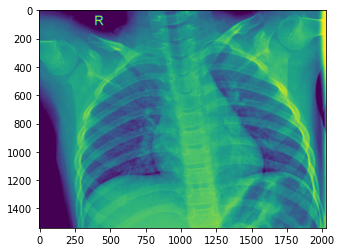

In [ ]:
from keras import models
from PIL import Image

img_upload = Image.open("/content/drive/MyDrive/TKC/chest_xray/test/NORMAL/NORMAL-1368583-0001.jpeg")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['/content/drive/MyDrive/TKC/model2.h5', '/content/drive/MyDrive/TKC/model3.h5']
labels = ['PNEUMONIA', 'NORMAL']

for m in model_list:
    model = models.load_model(m)
    # size_img = model.layers[0].output_shape[1:3]
    imgs = cv2.resize(img, (224,224))
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')

Model : model2.h5
Predicted Label : PNEUMONIA
Probability : 0.0022

Model : model3.h5
Predicted Label : PNEUMONIA
Probability : 0.018



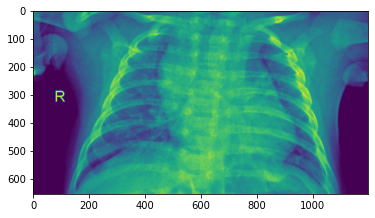

In [ ]:
img_upload = Image.open("/content/drive/MyDrive/TKC/chest_xray/test/PNEUMONIA/VIRUS-30184-0001.jpeg")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['/content/drive/MyDrive/TKC/model2.h5', '/content/drive/MyDrive/TKC/model3.h5']
labels = ['PNEUMONIA', 'NORMAL']

for m in model_list:
    model = models.load_model(m)
    # size_img = model.layers[0].output_shape[1:3]
    imgs = cv2.resize(img, (224,224))
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')